In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer-dataset/HAM10000_metadata.csv
/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer/ISIC_0030912.jpg
/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer/ISIC_0028933.jpg
/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer/ISIC_0030585.jpg
/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer/ISIC_0028394.jpg
/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer/ISIC_0033697.jpg
/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer/ISIC_0030062.jpg
/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer/ISIC_0031213.jpg
/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer/ISIC_0027799.jpg
/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer/ISIC_0028100.jpg
/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer/ISIC_0027960.jpg
/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer/ISIC_0028872.jpg
/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer/ISIC_0031317.jpg
/kaggle/input/skin-cancer-dataset/Skin Cance

# *Preprocess*

In [2]:
meta_data = pd.read_csv("/kaggle/input/skin-cancer-dataset/HAM10000_metadata.csv")
meta_data.loc[meta_data['dx'] != 'bkl'].head(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization
64,HAM_0001751,ISIC_0024698,nv,consensus,70.0,male,face
1095,HAM_0005276,ISIC_0027008,df,histo,75.0,male,back
1096,HAM_0005276,ISIC_0028790,df,histo,75.0,male,back


In [3]:
new_cols = ['Lesion_ID', 'Image_ID', 'Diagnosis', 'Diagnosis_Type', 'Age', 'Sex', 'Localization'] 
meta_data.columns = new_cols
meta_data.columns

Index(['Lesion_ID', 'Image_ID', 'Diagnosis', 'Diagnosis_Type', 'Age', 'Sex',
       'Localization'],
      dtype='object')

In [4]:
meta_data['Diagnosis'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [5]:
diagnosis_mapping = {
    'bkl': 'Benign_keratosis',
    'nv': 'Melanocytic_nevi',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'vasc': 'Vascular_lesions',
    'bcc': 'Basal cell_carcinoma',
    'akiec': 'Actinic_keratoses' 
}
meta_data['Updated_Diagnosis'] = meta_data['Diagnosis'].map(diagnosis_mapping)
meta_data['Updated_Diagnosis'].head(5)

0    Benign_keratosis
1    Benign_keratosis
2    Benign_keratosis
3    Benign_keratosis
4    Benign_keratosis
Name: Updated_Diagnosis, dtype: object

In [6]:
meta_data['Diagnosis_Type'].unique()

array(['histo', 'consensus', 'confocal', 'follow_up'], dtype=object)

In [7]:
diagnosis_type_mapping = {
    'histo': 'Histopathology',
    'consensus': 'Consensus',
    'confocal': 'Confocal Microscopy',
    'follow_up': 'Follow-Up Examination'
}
meta_data['Updated_DT'] = meta_data['Diagnosis_Type'].map(diagnosis_type_mapping)
meta_data['Updated_DT'].head()

0    Histopathology
1    Histopathology
2    Histopathology
3    Histopathology
4    Histopathology
Name: Updated_DT, dtype: object

In [8]:
meta_data.describe(include='all')

,Lesion_ID,Image_ID,Diagnosis,Diagnosis_Type,Age,Sex,Localization,Updated_Diagnosis,Updated_DT
count,10015,10015,10015,10015,9958.000000,10015,10015,10015,10015
unique,7470,10015,7,4,NaN,3,15,7,4
top,HAM_0003789,ISIC_0027419,nv,histo,NaN,male,back,Melanocytic_nevi,Histopathology
freq,6,1,6705,5340,NaN,5406,2192,6705,5340
mean,NaN,NaN,NaN,NaN,51.863828,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,16.968614,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,40.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,50.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,65.000000,NaN,NaN,NaN,NaN


In [9]:
meta_data['Age'].dtype

dtype('float64')

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from matplotlib.image import imread
import os

2024-05-29 23:53:54.522608: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 23:53:54.522763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 23:53:54.703333: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
path = "/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer"
dir_list = os.listdir(path)
dir_list[1:5]

['ISIC_0028933.jpg',
 'ISIC_0030585.jpg',
 'ISIC_0028394.jpg',
 'ISIC_0033697.jpg']

In [12]:
df = pd.DataFrame(columns=['Img_Array', 'Image_ID'])
df['Image_ID'] = dir_list
print(df.head(4))    

  Img_Array          Image_ID
0       NaN  ISIC_0030912.jpg
1       NaN  ISIC_0028933.jpg
2       NaN  ISIC_0030585.jpg
3       NaN  ISIC_0028394.jpg


[[151 159 152 ... 169 168 173]
 [147 151 152 ... 168 167 169]
 [151 144 139 ... 168 165 169]
 ...
 [151 150 150 ... 163 163 141]
 [150 152 149 ... 163 161 160]
 [149 146 147 ... 162 156 158]]


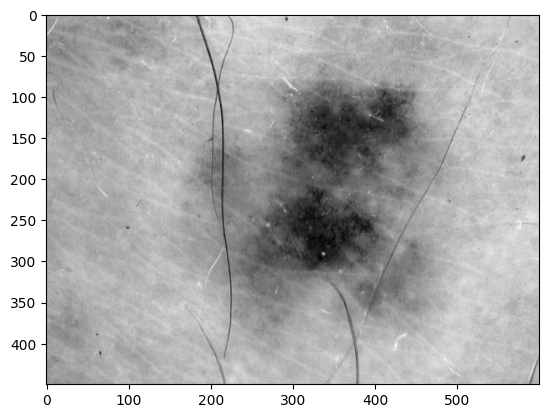

In [13]:
image = cv2.imread('/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer/ISIC_0024307.jpg')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
resized_image = cv2.resize(gray_image, (64, 64))
plt.imshow(gray_image, cmap='gray')
print(resized_image)

In [14]:
import pandas as pd
import cv2
import numpy as np
import os

image_dir = '/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer'

def preprocess_image(image_path, target_size=(128, 128)):
    # Read the image
    image = cv2.imread(image_path)
    
    # Check if the image is read correctly
    if image is None:
        return np.nan  # Return NaN if the image is not found or cannot be read
    
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Resize the image
    resized_image = cv2.resize(gray_image, target_size)
    
    # Normalize the image
    normalized_image = resized_image / 255.0
    
    flattened_image = normalized_image.flatten()

    return flattened_image

def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

def zoom_image(image, zoom_factor):
    h, w = image.shape[:2]
    new_h, new_w = int(h * zoom_factor), int(w * zoom_factor)
    zoomed = cv2.resize(image, (new_w, new_h))
    
    # Crop to the original size if zoomed in
    if zoom_factor > 1:
        startx = new_w // 2 - w // 2
        starty = new_h // 2 - h // 2
        zoomed = zoomed[starty:starty+h, startx:startx+w]
    
    # Pad to the original size if zoomed out
    if zoom_factor < 1:
        pad_h = (h - new_h) // 2
        pad_w = (w - new_w) // 2
        zoomed = cv2.copyMakeBorder(zoomed, pad_h, pad_h, pad_w, pad_w, cv2.BORDER_CONSTANT, value=0)
    
    return zoomed

def process_row(row):
    image_path = os.path.join(image_dir, row['Image_ID'])
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if original_image is None:
        return pd.Series({
            'original': np.nan,
            'rotated_90': np.nan,
            'rotated_180': np.nan,
            'rotated_270': np.nan,
            'zoomed_in': np.nan,
            'zoomed_out': np.nan
        })
    
    # Resize original image
    original_resized = cv2.resize(original_image, (128, 128))
    normalized_original = original_resized / 255.0
    flattened_original = normalized_original.flatten()

    # Rotate the image
    rotated_90 = rotate_image(original_resized, 90)
    rotated_180 = rotate_image(original_resized, 180)
    rotated_270 = rotate_image(original_resized, 270)
    
    # Normalize and flatten rotated images
    flattened_90 = (rotated_90 / 255.0).flatten()
    flattened_180 = (rotated_180 / 255.0).flatten()
    flattened_270 = (rotated_270 / 255.0).flatten()
    
    # Zoom the image
    zoomed_in = zoom_image(original_resized, 1.2)
    zoomed_out = zoom_image(original_resized, 0.8)
    
    # Normalize and flatten zoomed images
    flattened_zoomed_in = (zoomed_in / 255.0).flatten()
    flattened_zoomed_out = (zoomed_out / 255.0).flatten()

    return pd.Series({
        'original': flattened_original,
        'rotated_90': flattened_90,
        'rotated_180': flattened_180,
        'rotated_270': flattened_270,
        'zoomed_in': flattened_zoomed_in,
        'zoomed_out': flattened_zoomed_out
    })


In [15]:
df = df.join(df.apply(process_row, axis=1))


In [16]:
df.head()

,Img_Array,Image_ID,original,rotated_90,rotated_180,rotated_270,zoomed_in,zoomed_out
0,NaN,ISIC_0030912.jpg,"[0.37254901960784315, 0.3803921568627451, 0.38...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.3764705882352941, 0.3764705882352941, ...","[0.403921568627451, 0.4117647058823529, 0.4196...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,NaN,ISIC_0028933.jpg,"[0.6705882352941176, 0.6745098039215687, 0.643...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.6588235294117647, 0.6627450980392157, ...","[0.6470588235294118, 0.6901960784313725, 0.694...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,NaN,ISIC_0030585.jpg,"[0.47058823529411764, 0.4666666666666667, 0.47...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.44313725490196076, 0.4470588235294118,...","[0.5019607843137255, 0.49411764705882355, 0.48...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,NaN,ISIC_0028394.jpg,"[0.5803921568627451, 0.5803921568627451, 0.580...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.6078431372549019, 0.6039215686274509, ...","[0.5725490196078431, 0.5882352941176471, 0.588...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,NaN,ISIC_0033697.jpg,"[0.12156862745098039, 0.16862745098039217, 0.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.27058823529411763, 0.2784313725490196,...","[0.5843137254901961, 0.592156862745098, 0.5725...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [17]:
df['Image_ID'] = df['Image_ID'].astype(str)
print(df['Image_ID'].dtype)
print(df['Image_ID'].head(5))

object
0    ISIC_0030912.jpg
1    ISIC_0028933.jpg
2    ISIC_0030585.jpg
3    ISIC_0028394.jpg
4    ISIC_0033697.jpg
Name: Image_ID, dtype: object


So yeah we augmented the data across degrees in intervals of 90 :). Additionally, we also zoomed in and zoomed out of the picture to get different scaling samples that will help the model generalize across different skin cancer sizes.


In [18]:
meta_data['Image_ID'] = meta_data['Image_ID'].astype(str)

Need to add .jpg to correlate the two dataframes across the column 'Image_ID'

In [21]:
meta_data['Image_ID'] = meta_data['Image_ID'].str.replace('jpg.jpg', '')

In [22]:
meta_data['Image_ID']

0        ISIC_0027419
1        ISIC_0025030
2        ISIC_0026769
3        ISIC_0025661
4        ISIC_0031633
             ...     
10010    ISIC_0033084
10011    ISIC_0033550
10012    ISIC_0033536
10013    ISIC_0032854
10014    ISIC_0032258
Name: Image_ID, Length: 10015, dtype: object

In [23]:
meta_data['Image_ID'] = meta_data['Image_ID']  + '.jpg'

In [24]:
meta_data.loc[meta_data['Updated_Diagnosis'] == 'Melanocytic_nevi'].head(5)

,Lesion_ID,Image_ID,Diagnosis,Diagnosis_Type,Age,Sex,Localization,Updated_Diagnosis,Updated_DT
64,HAM_0001751,ISIC_0024698.jpg,nv,consensus,70.0,male,face,Melanocytic_nevi,Consensus
1210,HAM_0000559,ISIC_0024693.jpg,nv,follow_up,45.0,female,upper extremity,Melanocytic_nevi,Follow-Up Examination
2976,HAM_0004932,ISIC_0032212.jpg,nv,follow_up,45.0,female,foot,Melanocytic_nevi,Follow-Up Examination
2977,HAM_0004516,ISIC_0025775.jpg,nv,follow_up,45.0,female,neck,Melanocytic_nevi,Follow-Up Examination
2978,HAM_0006510,ISIC_0029828.jpg,nv,follow_up,55.0,female,lower extremity,Melanocytic_nevi,Follow-Up Examination


In [25]:
all_data = meta_data.merge(df, on='Image_ID')

# *Preprocessing Done!*

# *Exploratory Data Analysis*

In [26]:
all_data['Updated_Diagnosis'].unique()

array(['Benign_keratosis', 'Melanocytic_nevi', 'Dermatofibroma',
       'Melanoma', 'Vascular_lesions', 'Basal cell_carcinoma',
       'Actinic_keratoses'], dtype=object)

Looks like we have more MN diagnosis

In [27]:
male_mn_count = len(all_data.loc[(all_data['Sex'] == 'male') & (all_data['Updated_Diagnosis'] == 'Melanocytic_nevi')])
mn_prop_male = male_mn_count/6705.00
mn_prop_male

0.5102162565249814

Not much dispersion for Melanocytic nevi between genders

In [28]:
all_data.columns

Index(['Lesion_ID', 'Image_ID', 'Diagnosis', 'Diagnosis_Type', 'Age', 'Sex',
       'Localization', 'Updated_Diagnosis', 'Updated_DT', 'Img_Array',
       'original', 'rotated_90', 'rotated_180', 'rotated_270', 'zoomed_in',
       'zoomed_out'],
      dtype='object')

In [29]:
diagnosis_localization_counts = all_data.groupby(['Updated_Diagnosis', 'Localization']).size().reset_index(name='Count')
diagnosis_localization_counts = diagnosis_localization_counts.sort_values(by=['Updated_Diagnosis', 'Count'], ascending=False)
diagnosis_localization_counts = diagnosis_localization_counts.groupby('Updated_Diagnosis').head(1)

print(diagnosis_localization_counts)

       Updated_Diagnosis     Localization  Count
79      Vascular_lesions            trunk     31
59              Melanoma             back    324
52      Melanocytic_nevi  lower extremity   1479
41        Dermatofibroma  lower extremity     82
27      Benign_keratosis             face    319
12  Basal cell_carcinoma             back    186
4      Actinic_keratoses             face    113


Most frequent location for each diagnosis ^^

In [30]:
all_data['model_output'], _ = pd.factorize(all_data['Updated_Diagnosis'])

# *Model Creation*

In [31]:
import os
import cv2
import shutil
import random
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from tensorflow.keras import Sequential
from sklearn.metrics import confusion_matrix
from tensorflow.keras import models, layers
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization

In [32]:
from tensorflow.keras import models, layers, regularizers

model = models.Sequential([
    # Reshape the input from 1D to 2D
    layers.Reshape((64, 64, 1), input_shape=(64*64,)),
    
    # Convolutional layers for feature extraction
    layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten the output to feed into the dense layers
    layers.Flatten(),
    
    # Fully connected layers for classification
    layers.Dense(512, activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    layers.Dropout(0.75),  # Dropout layer to reduce overfitting
    
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    layers.Dropout(0.75),
    
    # Output layer with softmax activation for classification
    layers.Dense(10, activation='softmax',
                 kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))  # 10 output classes
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Display model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,354,442 (16.61 MB)

 Trainable params: 4,354,442 (16.61 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
image_columns = ['original', 'rotated_90', 'rotated_180', 'rotated_270', 'zoomed_in', 'zoomed_out']
#X_train = []
#y_train = []
#for index, row in all_data.iterrows():
#    for col in image_columns:
#        X_train.append(row[col])
#        y_train.append(row['model_output'])

# Convert the lists to numpy arrays
#X_train = np.array(X_train)
#y_train = np.array(y_train)


X = np.vstack([np.vstack(all_data[col].values) for col in image_columns])

# Repeat the labels for each image column
y = np.repeat(all_data['model_output'].values, len(image_columns))

In [34]:
print(X[:5])
print(y[:5])

[[0.65882353 0.6745098  0.66666667 ... 0.66666667 0.6627451  0.61568627]
 [0.07058824 0.07058824 0.07058824 ... 0.07843137 0.07058824 0.06666667]
 [0.56470588 0.6        0.61176471 ... 0.44705882 0.35294118 0.29411765]
 [0.05882353 0.05882353 0.0745098  ... 0.0627451  0.05882353 0.04313725]
 [0.4        0.43529412 0.4745098  ... 0.28627451 0.21176471 0.12941176]]
[0 0 0 0 0]


In [35]:
from sklearn.model_selection import train_test_split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
history = model.fit(X_train, y_train, epochs = 10)

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()